# 1. Эксперимент #

In [1]:
import threading

total = []
 
def doubler(number):
    """
    A function that can be used by a thread
    """
    
    global total
    total.append(i)
    
    print(threading.currentThread().getName() + '\n')
 
if __name__ == '__main__':
    for i in range(5):
        my_thread = threading.Thread(target=doubler, args=(i,))
        my_thread.start()
        
    print(total)

Thread-6

Thread-7

Thread-8

Thread-9
Thread-10

[0, 1, 2, 3, 4]



Цель работы - научиться применять нейронные сети для задачи классификации. Набор данных генерируется методом Монте Карло. Каждый класс содержит два признака - время замедления и колличество столкновений.

## Блок нейтронной физики ##

In [2]:
import pandas as pd
import random as rd
import math as math
import scipy.constants as const # Модуль физико-математических констант

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

N_A = const.Avogadro

### Функция жизни нейтрона: ###

In [3]:
# Для одинаковой генерации данных
rd.seed(42)

def life_of_neutron(Ein, Eout, dens, A1, A2, Mol_m, Sigma, alpha_1, alpha_2, sigma_1, sigma_2, x1, x2):
    
    Energy = Ein
    colision = 0 # Число столкновений
    time = 0 # Время полета
    a = 0 # Угол полета
    b = 0 # Изменение угла полета
    l = 0 # Длина пролета
    V = 0 # Скорость
    elder = 0 #Возраст
    while Energy > Eout: #Пока энергия нейтрона лежит в области > ... ЭВ
        l = -1*math.log(rd.random())/Sigma/100 # В метрах
        V = (2*Energy*1.6*(10**(-19))/(1.6749*10**(-27)))**0.5 # В м/с
        time += l/V
        colision += 1
        
        #Разыгрывание на каком ядре произошло рассеяние
        x = rd.random()
        if x < (x1*sigma_1/(x1*sigma_1 + x2*sigma_2)):# Рассеяние на первом ядре
            E1 = Energy
            E2 = Energy*alpha_1
            Energy = rd.uniform(E1, E2)
            b = math.acos

            
        else:# Рассеяние на втором ядре
            E1 = Energy
            E2 = Energy*alpha_2
            Energy = rd.uniform(E1, E2)

    return colision, time

### Входные данные по материалам: ###

In [4]:
df = pd.DataFrame({'Material': ['Water', 'Heavy Plexiglass', 'Heavy Water'],
                   'Density g/cm^3': [1.0, 1.6, 1.1],
                    'A_1' : [1, 12, 2],
                    'A_2' : [16, 2, 16],
                    'Molar mass g/mol' : [18, 28, 20],
                    'Chemical formula' : ['H2O', 'C2D2', 'D2O'],
                    'sigma_1 b' : [30.0, 4.9, 3.5],
                    'sigma_2 b' : [4.0, 3.5, 4.0],
                    'x1' : [2, 2, 2],
                    'x2' : [1, 2, 1],
                    
              })

df

Material  Density g/cm^3  A_1  A_2  Molar mass g/mol  \
0             Water             1.0    1   16                18   
1  Heavy Plexiglass             1.6   12    2                28   
2       Heavy Water             1.1    2   16                20   

  Chemical formula  sigma_1 b  sigma_2 b  x1  x2  
0              H2O       30.0        4.0   2   1  
1             C2D2        4.9        3.5   2   2  
2              D2O        3.5        4.0   2   1

### Расчет макросечения: ###

In [5]:
df['\u03A3, 1/cm'] = 0.0
for k in df.index:
    df['Σ, 1/cm'][k] = (df['x1'][k]*df['sigma_1 b'][k]+df['x2'][k]*df['sigma_2 b'][k]
                       )*N_A*df['Density g/cm^3'][k]/df['Molar mass g/mol'][k]/10**(24)
display(df)

Material  Density g/cm^3  A_1  A_2  Molar mass g/mol  \
0             Water             1.0    1   16                18   
1  Heavy Plexiglass             1.6   12    2                28   
2       Heavy Water             1.1    2   16                20   

  Chemical formula  sigma_1 b  sigma_2 b  x1  x2   Σ, 1/cm  
0              H2O       30.0        4.0   2   1  2.141206  
1             C2D2        4.9        3.5   2   2  0.578126  
2              D2O        3.5        4.0   2   1  0.364340

### Расчет ступеньки замедления: ###

In [6]:
df['\u0251_1'] = 0.0
df['\u0251_2'] = 0.0
for k in df.index:
    df['\u0251_1'][k] = ((df['A_1'][k]-1)/(df['A_1'][k]+1))**2
    df['\u0251_2'][k] = ((df['A_2'][k]-1)/(df['A_2'][k]+1))**2
display(df)

Material  Density g/cm^3  A_1  A_2  Molar mass g/mol  \
0             Water             1.0    1   16                18   
1  Heavy Plexiglass             1.6   12    2                28   
2       Heavy Water             1.1    2   16                20   

  Chemical formula  sigma_1 b  sigma_2 b  x1  x2   Σ, 1/cm       ɑ_1       ɑ_2  
0              H2O       30.0        4.0   2   1  2.141206  0.000000  0.778547  
1             C2D2        4.9        3.5   2   2  0.578126  0.715976  0.111111  
2              D2O        3.5        4.0   2   1  0.364340  0.111111  0.778547

### Создание DataFrame для записи данных ###

In [7]:
df1 = pd.DataFrame({'time, 10^(-5) c': [],
                   'colisions': [],
                    'Material' : [],
                    'target' : [] 
              })
df1

Empty DataFrame
Columns: [time, 10^(-5) c, colisions, Material, target]
Index: []

### Эксперимент методом Монте-Карло ###

In [8]:
Estart = 1_000_000 #1Мэв
Eend = 1 #1 Эв
Colision = [0, 0, 0, 0]
Time = [0, 0, 0, 0]
number_of_event = 300
counter = 0 # Счетчик для записи в DataFrame
for k in df.index: #Цикл по материалам
    for i in range(0, number_of_event*(k+1)): #Колличество событий для каждого материала
        colision, time = life_of_neutron(Estart, Eend, df['Density g/cm^3'][k],
                                          df['A_1'][k], df['A_2'][k],
                                          df['Molar mass g/mol'][k], df['Σ, 1/cm'][k],
                                          df['ɑ_1'][k], df['ɑ_2'][k],
                                          df['sigma_1 b'][k], df['sigma_2 b'][k],
                                          df['x1'][k], df['x2'][k],)
        df1.loc[counter] = {'Material': df['Material'][k], 'time, 10^(-5) c': time*100_000, 'colisions': colision, 'target': k}
        Colision[k]+=colision
        Time[k]+=time
        counter+=1




In [9]:
for k in df.index:
    Colision[k] = Colision[k]/number_of_event/(k+1)
    Time[k] = Time[k]/number_of_event/(k+1)
    
for k in df.index:
    print(df['Material'][k])
    print(Colision[k])
    print(Time[k])

Water
15.643333333333333
6.787573276044247e-07
Heavy Plexiglass
35.90833333333333
6.268212392367504e-06
Heavy Water
28.513333333333335
7.811704616661977e-06


# 2. Первичный анализ данных с помощью Pandas #

Посмотрим, что представляют собой полученные данные

In [10]:
df1.head()

time, 10^(-5) c  colisions Material  target
0         0.060134       18.0    Water     0.0
1         0.015265       11.0    Water     0.0
2         0.058799       17.0    Water     0.0
3         0.047027       14.0    Water     0.0
4         0.018141       10.0    Water     0.0

Сколько строк и столбцов

In [11]:
df1.shape

(1800, 4)

Общая информация

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time, 10^(-5) c  1800 non-null   float64
 1   colisions        1800 non-null   float64
 2   Material         1800 non-null   object 
 3   target           1800 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.3+ KB


In [13]:
df1['colisions'] = df1['colisions'].astype('int64')
df1['target'] = df1['target'].astype('int64')
df1['time, 10^(-5) c'] = df1['time, 10^(-5) c'].astype('float64')

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time, 10^(-5) c  1800 non-null   float64
 1   colisions        1800 non-null   int64  
 2   Material         1800 non-null   object 
 3   target           1800 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 70.3+ KB


Распределение числовых параметров

In [14]:
df1.describe()

time, 10^(-5) c    colisions       target
count      1800.000000  1800.000000  1800.000000
mean          0.610838    28.833333     1.333333
std           0.430306     9.030121     0.745563
min           0.005600     6.000000     0.000000
25%           0.297471    23.000000     1.000000
50%           0.555621    29.000000     1.500000
75%           0.853301    35.000000     2.000000
max           4.030266    59.000000     2.000000

Изменение типа данных с учетом значений

In [15]:
df1['colisions'] = df1['colisions'].astype('int8')
df1['target'] = df1['target'].astype('int8')
df1['time, 10^(-5) c'] = df1['time, 10^(-5) c'].astype('float64')

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time, 10^(-5) c  1800 non-null   float64
 1   colisions        1800 non-null   int8   
 2   Material         1800 non-null   object 
 3   target           1800 non-null   int8   
dtypes: float64(1), int8(2), object(1)
memory usage: 45.7+ KB


Описание не числовых типов данных

In [16]:
df1.describe(include=['object'])

Material
count          1800
unique            3
top     Heavy Water
freq            900

Распределение данных по целевой переменной

In [17]:
df1['target'].value_counts()

2    900
1    600
0    300
Name: target, dtype: int64

In [18]:
df1['target'].value_counts(normalize=True)

2    0.500000
1    0.333333
0    0.166667
Name: target, dtype: float64

Сортировка по убыванию colisions

In [19]:
df1 = df1.sort_values(by='colisions', ascending=False)
df1.head()

time, 10^(-5) c  colisions          Material  target
791         0.729316         59  Heavy Plexiglass       1
680         1.211173         58  Heavy Plexiglass       1
486         2.111941         57  Heavy Plexiglass       1
377         1.457662         56  Heavy Plexiglass       1
807         0.532553         55  Heavy Plexiglass       1

Сортировка по убыванию time, 10^(-5) c

In [20]:
df1 = df1.sort_values(by='time, 10^(-5) c', ascending=False)
df1.head()

time, 10^(-5) c  colisions     Material  target
1762         4.030266         40  Heavy Water       2
1246         2.830374         37  Heavy Water       2
1267         2.784204         31  Heavy Water       2
907          2.492663         42  Heavy Water       2
1013         2.417235         29  Heavy Water       2

Сортировка по возрастанию colisions

In [21]:
df1 = df1.sort_values(by='colisions', ascending=True)
df1.head()

time, 10^(-5) c  colisions Material  target
280         0.013819          6    Water       0
129         0.039810          6    Water       0
178         0.019329          7    Water       0
61          0.017364          7    Water       0
44          0.017380          7    Water       0

In [22]:
import numpy as np

Максимум по каждому признаку

In [23]:
df1.apply(np.max)

time, 10^(-5) c    4.03027
colisions               59
Material             Water
target                   2
dtype: object

Группировка данных

In [24]:
columns_to_show = ['time, 10^(-5) c', 'colisions']
df1.groupby(['target'])[columns_to_show].describe(percentiles=[0.25, 0.50, 0.99])

time, 10^(-5) c                                                    \
                 count      mean       std       min       25%       50%   
target                                                                     
0                300.0  0.067876  0.052758  0.005600  0.031281  0.053436   
1                600.0  0.626821  0.300871  0.122030  0.386285  0.576300   
2                900.0  0.781170  0.426260  0.047984  0.472239  0.689330   

                           colisions                                         \
             99%       max     count       mean       std   min   25%   50%   
target                                                                        
0       0.236044  0.388820     300.0  15.643333  3.967610   6.0  13.0  16.0   
1       1.390077  2.111941     600.0  35.908333  7.160217  16.0  31.0  35.0   
2       1.994400  4.030266     900.0  28.513333  5.675782  15.0  24.0  28.0   

                     
          99%   max  
target               
0       26.00  27.0  
1       54.01  59.0  
2       42.00  48.0

In [25]:
df1.groupby(['target'])[columns_to_show].agg([np.mean, np.std, np.min, np.max])

time, 10^(-5) c                                colisions            \
                  mean       std      amin      amax       mean       std   
target                                                                      
0             0.067876  0.052758  0.005600  0.388820  15.643333  3.967610   
1             0.626821  0.300871  0.122030  2.111941  35.908333  7.160217   
2             0.781170  0.426260  0.047984  4.030266  28.513333  5.675782   

                  
       amin amax  
target            
0         6   27  
1        16   59  
2        15   48

Cредние значения по признакам в зависимости от target

In [26]:
df1.pivot_table(['colisions', 'time, 10^(-5) c'], ['target'], aggfunc='mean').head(10)

colisions  time, 10^(-5) c
target                            
0       15.643333         0.067876
1       35.908333         0.626821
2       28.513333         0.781170

# 3. Визуализация экспериментальных данных  #

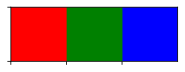

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
mpl.rcParams["xtick.bottom"] = True

flatui = ["red", "green", "blue"]
sns.palplot(sns.color_palette(flatui))

sns.set(font_scale = 1.5,
       style='white',
       palette=flatui,
       )

sns.set_style("ticks", {"xtick.bottom": True})

Распределение столкновений

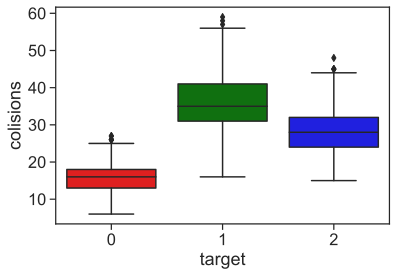

In [28]:
sns.boxplot(y="colisions", x="target",
            data=df1)

Распределение времени

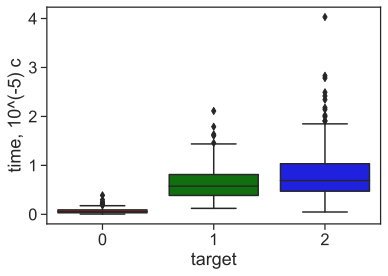

In [29]:
sns.boxplot(y="time, 10^(-5) c", x="target",
            data=df1)

Карта распрделений

In [30]:
df1['colisions'] = df1['colisions']/100
df1.rename(columns={'colisions': 'colisions, 10^2'}, inplace=True)

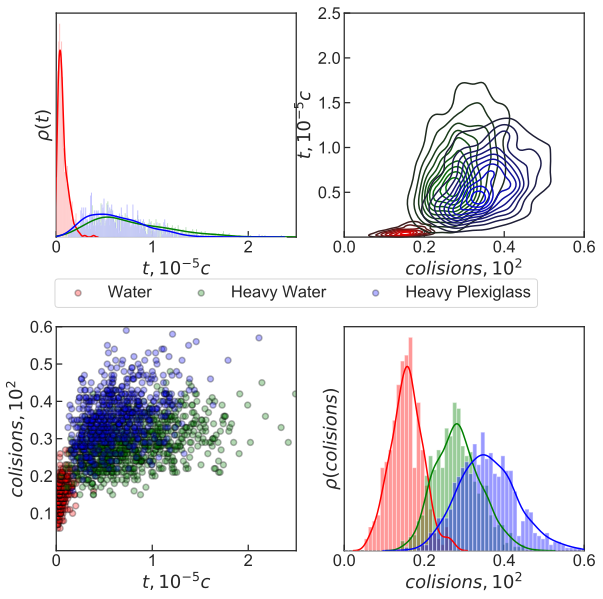

In [31]:
sns.set(font_scale = 1.5,
       style='white',
       )

g = sns.PairGrid(df1[['time, 10^(-5) c','colisions, 10^2', 'Material']],
                 hue='Material',
                 height=5.5,
                 palette= flatui,
                 despine = False,
                 hue_kws={
                     "marker": ["o", "o", "o"]
                 })

g.map_diag(sns.distplot, norm_hist = True, bins = np.linspace(0.0, 2.4, num=(6*4*10), endpoint=True))
g.map_upper(sns.kdeplot, shade=False, shade_lowest=False)
g.map_lower(plt.scatter, s = 35, alpha=0.3, linewidth=1.5, edgecolor="black")
g.fig.set_size_inches(8, 8)


plt.legend(loc='upper center', bbox_to_anchor=(1, 1.25), ncol=3) #vertical legend

# Подписи к осям
g.axes[0,0].yaxis.set_label_text(r'$\rho (t) $')
g.axes[0,0].xaxis.set_label_text('$t, 10^{-5} c$')
g.axes[1,1].yaxis.set_label_text(r'$\rho (colisions) $')
g.axes[1,1].xaxis.set_label_text('$colisions, 10^{2}$')
g.axes[1,0].yaxis.set_label_text('$colisions, 10^{2}$')
g.axes[1,0].xaxis.set_label_text('$t, 10^{-5} c$')
g.axes[0,1].yaxis.set_label_text('$t, 10^{-5} c$')
g.axes[0,1].xaxis.set_label_text('$colisions, 10^{2}$')

# Тики видны на y
g.axes[0,0].yaxis.set_tick_params(labelleft=False)
g.axes[1,1].yaxis.set_tick_params(labelleft=False)
g.axes[1,0].yaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[0,1].yaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')

# Тики видны на x
g.axes[0,0].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[1,1].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[1,0].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')
g.axes[0,1].xaxis.set_tick_params(labelleft=True, bottom = True, direction = 'in')

#Лимиты тиков на x
g.axes[1,0].set_xlim(0, 2.5)
g.axes[0,1].set_xlim(0, 0.6)

#Лимиты тиков на y
g.axes[1,0].set_ylim(0.00001, 0.6)
g.axes[0,0].set_ylim(0.00001, 2.5)

plt.subplots_adjust(hspace=0.4, wspace=0.2)

# 4. Классификация DL #

<img src="DL.PNG">

## 4.1 Подготовка тренировочной и тестовой выборок ##

In [32]:
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model

In [33]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    df1[['time, 10^(-5) c', 'colisions, 10^2']], df1[['target']],
    test_size = 0.3, random_state = 0)

Посмотрим что из себя представляет тестовая выборка

In [34]:
train_data

time, 10^(-5) c  colisions, 10^2
1322         1.115591             0.36
665          0.355155             0.34
1036         1.014331             0.24
448          1.039403             0.41
1173         0.753849             0.36
...               ...              ...
1508         0.392397             0.28
1251         1.355760             0.33
307          0.426035             0.41
1774         1.389666             0.25
1419         1.077003             0.26

[1260 rows x 2 columns]

Сравним тестовую и обучающую выборки с исходным набором данных

In [35]:
display(df1.describe())
display(test_data.describe())
display(train_data.describe())

time, 10^(-5) c  colisions, 10^2       target
count      1800.000000      1800.000000  1800.000000
mean          0.610838         0.288333     1.333333
std           0.430306         0.090301     0.745563
min           0.005600         0.060000     0.000000
25%           0.297471         0.230000     1.000000
50%           0.555621         0.290000     1.500000
75%           0.853301         0.350000     2.000000
max           4.030266         0.590000     2.000000

time, 10^(-5) c  colisions, 10^2
count       540.000000       540.000000
mean          0.588317         0.282926
std           0.407748         0.091097
min           0.005684         0.060000
25%           0.288450         0.227500
50%           0.541721         0.285000
75%           0.834502         0.340000
max           2.784204         0.590000

time, 10^(-5) c  colisions, 10^2
count      1260.000000      1260.000000
mean          0.620490         0.290651
std           0.439424         0.089895
min           0.005600         0.060000
25%           0.302516         0.230000
50%           0.562695         0.290000
75%           0.859373         0.350000
max           4.030266         0.580000

Сравним частоту попадания каждого класса в исходном наборе, тестовой и тренировочной выборках

In [36]:
display(df1['target'].value_counts(normalize=True))
display(test_labels['target'].value_counts(normalize=True))
display(train_labels['target'].value_counts(normalize=True))

2    0.500000
1    0.333333
0    0.166667
Name: target, dtype: float64

2    0.507407
1    0.318519
0    0.174074
Name: target, dtype: float64

2    0.496825
1    0.339683
0    0.163492
Name: target, dtype: float64

## 4.2 Метрики точности ##

Precision (точность) можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными (Реально Water из всех определенных Water):

\begin{align*} precision = {\frac{TP}{TP+FP}} \end{align*}

Recall (полнота) показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм (Сколько Water определено как Water):

\begin{align*} recall = {\frac{TP}{TP+FN}} \end{align*}

## 4.3 Метод обратного распространения ошибки ##

### Один нейрон ###

\begin{align*} y = f(w \cdot x + b) \end{align*}

\begin{align*} w = (0, 1) \end{align*}

\begin{align*} x = (2, 3) \end{align*}

\begin{align*} b = 4 \end{align*}

\begin{align*} (w \cdot x)+b = ((w_{1} * x_{1})+(w_{2} * x_{2}))+b = 0*2+1*3+4=7 \end{align*}

###  Функция активации ###

\begin{align*} y=f(x)=\frac{1}{1+e^{-x}} \end{align*}

### Объединим 2 нейрона в одну сеть ###

\begin{align*} h1=h2 = f(w \cdot x + b) \end{align*}

\begin{align*} o_{1} = f(w \cdot(h1, h2) + b) \end{align*}

### Тренировка нейронной сети ###

\begin{align*} L = L(w1,w2,w3,w4,w5,w6,b1,b2,b3) \end{align*}

\begin{align*} L = MSE = \frac{1}{n} \sum^{n}_{i=1} ({y_{true}-y_{pred}})^{2} \end{align*}

\begin{align*} y_{pred} = o1 = f(w5h1+w6h2+b3) \end{align*}

\begin{align*} h1 = f(w1 x1 + w2 x2 + b1) \end{align*}

\begin{align*} h2 = f(w3 x1 + w4 x2 + b2) \end{align*}

\begin{align*}
\frac{\partial L}{\partial w1} = 
\frac{\partial L}{\partial y_{pred}} *
\frac{\partial y_{pred}}{\partial h1} *
\frac{\partial h1}{\partial w1}
\end{align*}

\begin{align*}
1. \frac{\partial L}{y_{pred}}
\end{align*}

\begin{align*}
2. \frac{\partial L}{\partial h1} = 
\frac{\partial L}{\partial y_{pred}} *
\frac{\partial y_{pred}}{\partial h1}
\end{align*}

\begin{align*} \frac{\partial y_{pred}}{\partial h1} =
w5*f^\prime (w5h1+w6h2+b3)
\end{align*}

\begin{align*} f(x) = \frac{1}{1+e^{-x}} \end{align*}

\begin{align*} f^{\prime}(x) = \frac{e^{-x}}{(1+e^{-x})^{2}}
= f(x) * (1-f(x)) \end{align*}

\begin{align*} 3.
\frac{\partial L}{\partial w1} = 
\frac{\partial L}{\partial y_{pred}} *
\frac{\partial y_{pred}}{\partial h1} *
\frac{\partial h1}{\partial w1}
\end{align*}

\begin{align*} \frac{\partial h1}{\partial w1} =
x1*f^\prime (w1x1+w2x2+b1)
\end{align*}

Эта система подсчета частных производных при работе в обратном порядке известна, как метод обратного распространения ошибки, или backprop

\begin{align*}
w1 = w1 - \eta
\frac{\partial L}{\partial w1}
\end{align*}

Если $ \frac{\partial L}{\partial w1} $ положительная, w1 уменьшается, что приведет к уменьшению L

Если $ \frac{\partial L}{\partial w1} $ отрицательна, w1 увеличится, что приведет к уменьшению L

Если мы применим это на каждый вес и смещение в сети, потеря будет постепенно снижаться, а показатели сети сильно улучшатся

## 4.4 Scikit learn Perceptron

In [37]:
from sklearn.linear_model import Perceptron as skPerceptron

In [38]:
sk_perceptron = skPerceptron(random_state=0)
sk_perceptron.fit(train_data, train_labels)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
from sklearn import metrics

In [40]:
model_predictions_sk_perceptron = sk_perceptron.predict(test_data)
print(metrics.accuracy_score(test_labels, model_predictions_sk_perceptron))
print(metrics.classification_report(test_labels, model_predictions_sk_perceptron))

0.7407407407407407
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        94
           1       0.58      0.85      0.69       172
           2       0.86      0.59      0.70       274

    accuracy                           0.74       540
   macro avg       0.79      0.80      0.78       540
weighted avg       0.78      0.74      0.74       540



In [41]:
new_df = test_data
new_df['target'] = test_labels

new_df_0 = new_df
new_df_1 = new_df
new_df_2 = new_df

new_df_0 = new_df_0.drop(new_df_0[new_df_0.target != 0].index)
new_df_1 = new_df_1.drop(new_df_1[new_df_1.target != 1].index)
new_df_2 = new_df_2.drop(new_df_2[new_df_2.target != 2].index)

In [42]:
error = [] # 1, если ошибка, 0 если правильно
time = []
colisions = []

np_test_labels = test_labels['target'].to_numpy()
np_test_time = test_data['time, 10^(-5) c'].to_numpy()
np_test_colisions = test_data['colisions, 10^2'].to_numpy()

for i in range(len(np_test_labels)):
    if np_test_labels[i] == model_predictions_sk_perceptron[i]:
        error.append(0)
    else:
        error.append(1)
        
for i in range(len(error)):
    if error[i] == 1:
        time.append(np_test_time[i])
        colisions.append(np_test_colisions[i]) 

In [43]:
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green','blue'])

fig = plt.figure(figsize=(12,16))

#  Заголовок области Figure:
fig.suptitle('Perceptron sklearn',
             y= 0.93,
             fontsize = 20)

plt.subplots_adjust(wspace=0.15, hspace=0.2)

ax_1 = fig.add_subplot(3, 2, 1)
ax_2 = fig.add_subplot(3, 2, 4)
ax_3 = fig.add_subplot(3, 2, 3)
ax_4 = fig.add_subplot(3, 2, 2)

ax_1.set_xlim(0, 3)
ax_1.set_ylim(0, 0.7)
ax_2.set_xlim(0, 3)
ax_2.set_ylim(0, 0.7)
ax_3.set_xlim(0, 3)
ax_3.set_ylim(0, 0.7)
ax_4.set_xlim(0, 3)
ax_4.set_ylim(0, 0.7)

ax_1.set(title = 'Разделяющая поверхность')
def get_grid():
    x_min, x_max = 0, 4
    y_min, y_max = 0, 1
    return np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
xx, yy = get_grid()
predicted = sk_perceptron.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax_1.pcolormesh(xx, yy, predicted, cmap=colors, alpha = 0.7)
ax_1.scatter(test_data['time, 10^(-5) c'], test_data['colisions, 10^2'], c=test_labels['target'], s=15,
             cmap=colors, edgecolors='black', linewidth=1.5)
ax_1.set_ylabel('colisions, 10^2')
ax_1.set_xlabel('time, 10^(-5) c')


ax_2.set(title = 'Тестовый набор')
ax_2.scatter(new_df_0['time, 10^(-5) c'], new_df_0['colisions, 10^2'], c='red',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5, label = 'Water')
ax_2.scatter(new_df_1['time, 10^(-5) c'], new_df_1['colisions, 10^2'], c='green',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5, label = 'Heavy Plexiglass')
ax_2.scatter(new_df_2['time, 10^(-5) c'], new_df_2['colisions, 10^2'], c='blue',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5, label = 'Heavy Water')
ax_2.set_ylabel('colisions, 10^2')
ax_2.set_xlabel('time, 10^(-5) c')
ax_2.set_title('Тестовый набор')
ax_2.set_xlim(left = 0)
ax_2.legend()

ax_3.set(title = 'Модель')
ax_3.scatter(test_data['time, 10^(-5) c'], test_data['colisions, 10^2'], c=model_predictions_sk_perceptron, cmap=colors, s = 15
            , edgecolors = 'black', linewidths = 1, alpha = 0.5)
ax_3.set_ylabel('colisions, 10^2')
ax_3.set_xlabel('time, 10^(-5) c')
ax_3.set_title('Модель')
ax_3.set_xlim(left = 0)

ax_4.set(title = 'Ошибки')
ax_4.pcolormesh(xx, yy, predicted, cmap=colors, alpha = 0.7)
ax_4.scatter(time, colisions, c='yellow',
               s = 15, edgecolors = 'black', linewidths = 1, alpha = 0.5)
ax_4.set_ylabel('colisions, 10^2')
ax_4.set_xlabel('time, 10^(-5) c')
ax_4.set_title('Ошибки')
ax_4.set_xlim(left = 0)
ax_4.set_xlim(right = 3)
ax_4.set_ylim(bottom = 0)
ax_4.set_ylim(top = 0.7)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

print(metrics.classification_report(test_labels, model_predictions_sk_perceptron))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        94
           1       0.58      0.85      0.69       172
           2       0.86      0.59      0.70       274

    accuracy                           0.74       540
   macro avg       0.79      0.80      0.78       540
weighted avg       0.78      0.74      0.74       540



## 4.5 PyTorch Азы

In [44]:
import torch

torch.HalfTensor      # 16 бит, с плавающей точкой
torch.FloatTensor     # 32 бита,  с плавающей точкой
torch.DoubleTensor    # 64 бита, с плавающей точкой

torch.ShortTensor     # 16 бит, целочисленный, знаковый
torch.IntTensor       # 32 бита, целочисленный, знаковый
torch.LongTensor      # 64 бита, целочисленный, знаковый

torch.CharTensor      # 8 бит, целочисленный, знаковый
torch.ByteTensor      # 8 бит, целочисленный, беззнаковый

torch.ByteTensor

Создание Тензора

In [45]:
a = torch.FloatTensor([1, 2])
a

tensor([1., 2.])

In [46]:
a.shape

torch.Size([2])

In [47]:
b = torch.FloatTensor([[1,2,3], [4,5,6]])
b

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [48]:
b.shape

torch.Size([2, 3])

In [49]:
x = torch.IntTensor(3, 2).zero_()
x

tensor([[0, 0],
        [0, 0],
        [0, 0]], dtype=torch.int32)

Операторы

Сложение

In [50]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [51]:
a.add(b)

tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [200., 400., 600.]])

Вычитание

In [52]:
a.sub(b)

tensor([[ 2.,  4.,  6.],
        [20., 40., 60.],
        [ 0.,  0.,  0.]])

Умножение поэлементное

In [53]:
a.mul(b)

tensor([[-1.0000e+00, -4.0000e+00, -9.0000e+00],
        [-1.0000e+02, -4.0000e+02, -9.0000e+02],
        [ 1.0000e+04,  4.0000e+04,  9.0000e+04]])

Деление поэлементное

In [54]:
a.div(b)

tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [ 1.,  1.,  1.]])

Операторы сравнения

In [55]:
a == b

tensor([[False, False, False],
        [False, False, False],
        [ True,  True,  True]])

In [56]:
a != b

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False, False]])

In [57]:
a < b

tensor([[False, False, False],
        [False, False, False],
        [False, False, False]])

In [58]:
a > b

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False, False]])

Стандартные функции как в numpy

In [59]:
a.log()

tensor([[0.0000, 0.6931, 1.0986],
        [2.3026, 2.9957, 3.4012],
        [4.6052, 5.2983, 5.7038]])

In [60]:
a.sum()

tensor(666.)

In [61]:
a.mean()

tensor(74.)

По осям:

In [62]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [63]:
a.sum(0)

tensor([111., 222., 333.])

In [64]:
a.sum(1)

tensor([  6.,  60., 600.])

In [65]:
a.max()

tensor(300.)

In [66]:
a.max(0)

torch.return_types.max(
values=tensor([100., 200., 300.]),
indices=tensor([2, 2, 2]))

Матричные операции

Транспонирование

In [67]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [68]:
a.t()

tensor([[  1.,  10., 100.],
        [  2.,  20., 200.],
        [  3.,  30., 300.]])

Скалярное произведение векторов

In [69]:
a = torch.FloatTensor([1, 2, 3, 4, 5, 6])
b = torch.FloatTensor([-1, -2, -4, -6, -8, -10])

In [70]:
a.dot(b)

tensor(-141.)

In [71]:
a @ b

tensor(-141.)

Матричное умножение 

In [72]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [73]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [74]:
b

tensor([[ -1.,  -2.,  -3.],
        [-10., -20., -30.],
        [100., 200., 300.]])

In [75]:
a.mm(b)

tensor([[  279.,   558.,   837.],
        [ 2790.,  5580.,  8370.],
        [27900., 55800., 83700.]])

In [76]:
a @ b

tensor([[  279.,   558.,   837.],
        [ 2790.,  5580.,  8370.],
        [27900., 55800., 83700.]])

In [77]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1], [-10], [100]])

In [78]:
print(a.shape, b.shape)

torch.Size([3, 3]) torch.Size([3, 1])


In [79]:
a.mm(b)

tensor([[  279.],
        [ 2790.],
        [27900.]])

In [80]:
b.view(-1)

tensor([ -1., -10., 100.])

Перевод из numpy в pytorch

In [81]:
import numpy as np

a = np.random.rand(3, 3)
a

array([[0.93742986, 0.20679174, 0.52165954],
       [0.6577072 , 0.23251101, 0.03560732],
       [0.212084  , 0.1885048 , 0.81962154]])

In [82]:
b = torch.from_numpy(a)
b

tensor([[0.9374, 0.2068, 0.5217],
        [0.6577, 0.2325, 0.0356],
        [0.2121, 0.1885, 0.8196]], dtype=torch.float64)

a и b в этом случае будут использовать одно и то же хранилище данных, то есть измение одного тензора будет менять и другой

In [83]:
b -= b
b

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [84]:
a

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Перевод из pytorch в numpy

In [85]:
a = torch.FloatTensor(2, 3)

In [86]:
a

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [87]:
x = a.numpy()
x

array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

## 4.6 CUDA

In [88]:
x = torch.FloatTensor(1024, 1024).uniform_()
x

tensor([[0.0168, 0.1276, 0.4885,  ..., 0.0578, 0.4711, 0.7802],
        [0.8202, 0.2384, 0.5808,  ..., 0.3966, 0.1582, 0.1022],
        [0.8662, 0.7497, 0.5461,  ..., 0.3250, 0.9020, 0.9450],
        ...,
        [0.7584, 0.3309, 0.5989,  ..., 0.0279, 0.0863, 0.6848],
        [0.9468, 0.3958, 0.7876,  ..., 0.9646, 0.7830, 0.6074],
        [0.9608, 0.8199, 0.8123,  ..., 0.7358, 0.5259, 0.5467]])

In [89]:
x.is_cuda

False

In [90]:
x = x.cuda()

In [91]:
x.is_cuda

True

In [92]:
a = torch.FloatTensor(10000, 10000).uniform_()
b = torch.FloatTensor(10000, 10000).uniform_()
c = a.cuda().mul(b.cuda()).cpu()

Сравнение времени перемножения

In [93]:
a.is_cuda

False

In [94]:
b.is_cuda

False

In [95]:
from datetime import datetime
import time

In [96]:
start_time = datetime.now()
c = a.mul(b)
print(datetime.now() - start_time)

0:00:00.098454


In [97]:
a = a.cuda()
a.is_cuda

True

In [98]:
b = b.cuda()
b.is_cuda

True

In [99]:
start_time = datetime.now()
c = a.mul(b)
print(datetime.now() - start_time)

0:00:00.072766


## 4.7 Однослойная нейронная сеть на pytorch

In [100]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

In [101]:
X.shape

(300, 2)

In [102]:
y.shape

(300,)

In [103]:
train_data.head(2)

time, 10^(-5) c  colisions, 10^2
1322         1.115591             0.36
665          0.355155             0.34

In [104]:
train_data.shape

(1260, 2)

In [105]:
train_labels.head(2)

target
1322       2
665        1

In [106]:
train_labels.shape

(1260, 1)

In [107]:
X = train_data.to_numpy()
y = train_labels['target'].to_numpy()

In [108]:
y

array([2, 1, 2, ..., 1, 2, 2], dtype=int8)

In [109]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [110]:
print(X.data.shape, y.data.shape)

torch.Size([1260, 2]) torch.Size([1260])


In [111]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 10, 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 5e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    if t % 10 == 50:
        print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

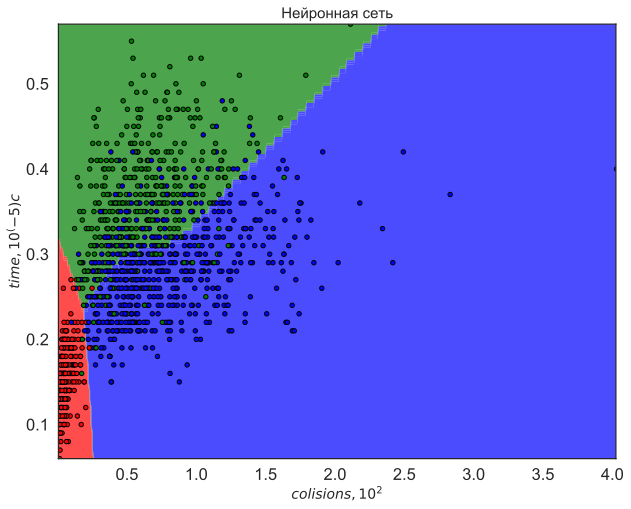

In [112]:
h = 0.01
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=colors, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=colors, edgecolors='black', linewidth=1.0)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Нейронная сеть', fontsize=15)
plt.xlabel('$colisions, 10^2$', fontsize=14)
plt.ylabel('$time, 10^(-5) c$', fontsize=14)
plt.show();

In [113]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 15, 2, 5, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 5e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    if t % 10 == 50:
        print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

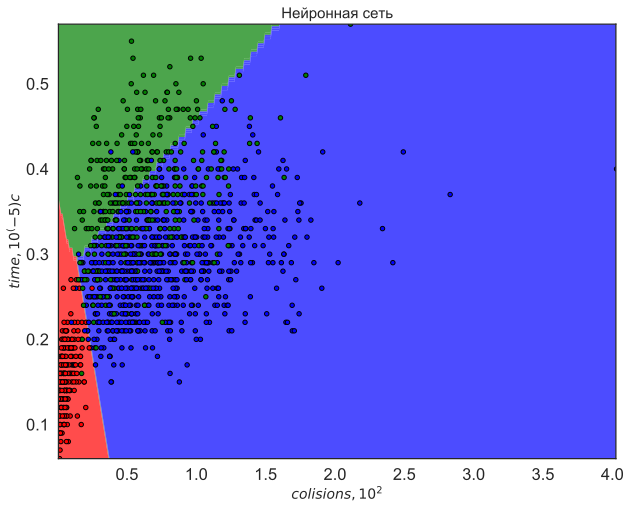

In [114]:
h = 0.01
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=colors, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=colors, edgecolors='black', linewidth=1.0)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Нейронная сеть', fontsize=15)
plt.xlabel('$colisions, 10^2$', fontsize=14)
plt.ylabel('$time, 10^(-5) c$', fontsize=14)
plt.show();

## 4.8 Многослойная нейронная сеть на pytorch

In [115]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 10, 2, 5, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 5e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

start_time = datetime.now()

for t in range(500):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    if t % 10 == 50:
        print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()
    
print("Время работы на CPU")
print(datetime.now() - start_time)

Время работы на CPU
0:00:01.269730


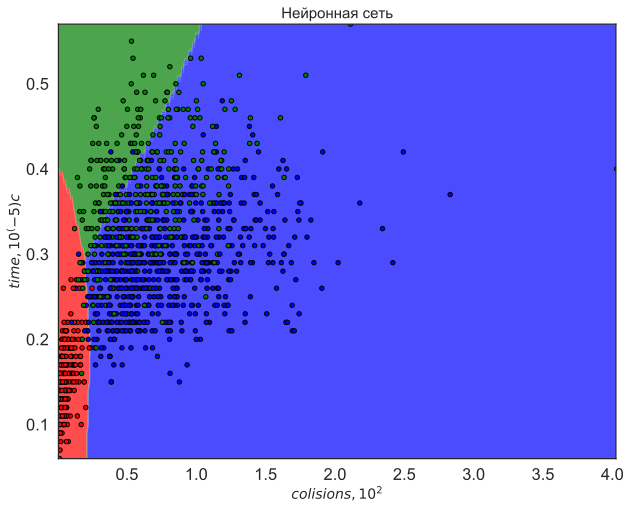

In [116]:
h = 0.01
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=colors, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=colors, edgecolors='black', linewidth=1.0)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Нейронная сеть', fontsize=15)
plt.xlabel('$colisions, 10^2$', fontsize=14)
plt.ylabel('$time, 10^(-5) c$', fontsize=14)
plt.show();

## 4.9 Многослойная нейронная сеть на pytorch CUDA

In [117]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 10, 2, 5, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

In [118]:
# Проверка доступа к видеокарте
torch.cuda.is_available()

True

In [119]:
# Имя доступной видеокарты
torch.cuda.get_device_name(0)

'GeForce GTX 1650 Ti'

In [120]:
# Тензор регрессоров
X

tensor([[1.1156, 0.3600],
        [0.3552, 0.3400],
        [1.0143, 0.2400],
        ...,
        [0.4260, 0.4100],
        [1.3897, 0.2500],
        [1.0770, 0.2600]])

In [121]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [122]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
print(dev)
device = torch.device(dev)  

cuda:0


In [123]:
X.is_cuda

False

In [124]:
X = X.to(device)

In [125]:
X.is_cuda

True

In [126]:
# тензор ответов предсказанных
y_pred = y_pred.to(device)
y_pred.is_cuda

True

In [127]:
# тензор правильных ответов
y = y.to(device)
y.is_cuda

True

In [128]:
#Нейронная сеть
two_layer_net

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=3, bias=True)
)

In [129]:
two_layer_net = two_layer_net.to(device)

In [130]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 5e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

start_time = datetime.now()

for t in range(500):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    if t % 10 == 50:
        print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()
    
print("Время работы на GPU")
print(datetime.now() - start_time)

Время работы на CPU
0:00:01.455679


In [131]:
X = X.to('cpu')
y_pred = y_pred.to('cpu')
y = y.to('cpu')

In [132]:
two_layer_net = two_layer_net.to('cpu')

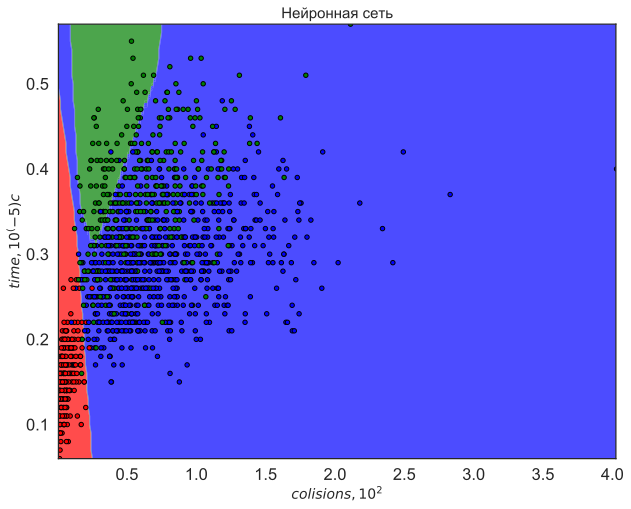

In [133]:
h = 0.01
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=colors, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=colors, edgecolors='black', linewidth=1.0)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Нейронная сеть', fontsize=15)
plt.xlabel('$colisions, 10^2$', fontsize=14)
plt.ylabel('$time, 10^(-5) c$', fontsize=14)
plt.show();